In [220]:
from collections import deque
import pandas as pd
import numpy as np
from typing import Tuple
import scipy.stats as st


def format_seconds(x: float) -> str:
    return r"\SI{" f"{x:0.02f}" r"}{\second}"

fits_df = pd.read_csv("./measure_latency/results/fits.csv")

print(
    pd.DataFrame(fits_df)
    .to_latex(
        index=False,
        formatters={
            "mean": format_seconds,
            "jitter": lambda x: r"$ \pm " + format_seconds(x) + " $",
            "shape": lambda x: r"\num{" f"{x:0.02f}" r"}",
            "scale": format_seconds,
        }
    )
)    

\begin{tabular}{rrrr}
\toprule
mean & jitter & shape & scale \\
\midrule
\SI{0.10}{\second} & $ \pm \SI{0.02}{\second} $ & \num{4.50} & \SI{0.09}{\second} \\
\SI{0.20}{\second} & $ \pm \SI{0.04}{\second} $ & \num{6.26} & \SI{0.18}{\second} \\
\SI{0.40}{\second} & $ \pm \SI{0.08}{\second} $ & \num{6.84} & \SI{0.35}{\second} \\
\SI{0.80}{\second} & $ \pm \SI{0.16}{\second} $ & \num{7.75} & \SI{0.70}{\second} \\
\SI{1.60}{\second} & $ \pm \SI{0.32}{\second} $ & \num{7.69} & \SI{1.39}{\second} \\
\SI{3.20}{\second} & $ \pm \SI{0.64}{\second} $ & \num{7.59} & \SI{2.78}{\second} \\
\bottomrule
\end{tabular}



In [94]:
import pandas as pd

experiment_cats = pd.CategoricalDtype(["packet", "frame", "step"], ordered=True)

step_frame_data = pd.read_csv('per_frame_step_delay_new_pareto_params.csv')
step_frame_data["model"] = step_frame_data["model"].replace({
    "first-order": "Ref. Stochastic",
    "first-order-median": "Ref. Median",
    "3rd-poly-low": "3rd Order Poly. (low neuroticism)",  # multi-curve always fits 3rd
    "3rd-poly-high": "3rd Order Poly. (high neuroticism)",
    "legacy": "Legacy EdgeDroid 1.0"
}).astype("category")
step_frame_data["mean/var"] = step_frame_data[["gamma_mean", "gamma_var"]].apply(lambda row: f"{row.gamma_mean:1.2f} / {row.gamma_var:1.2f}", axis=1)
for col in ["rho", "gamma_loc", "gamma_scale", "gamma_shape", "gamma_mean", "gamma_var", "mean/var"]:
    step_frame_data[col] = step_frame_data[col].astype(pd.CategoricalDtype(sorted(step_frame_data[col].unique()), ordered=True))
    
step_frame_data["experiment"] = step_frame_data["experiment"].astype(experiment_cats)

step_frame_data["task_duration"] = step_frame_data.groupby(["experiment", "model", "rho", "gamma_loc", "gamma_scale", "gamma_shape", "mean/var", "rep"], observed=True)["step_duration"].cumsum()
step_frame_data.groupby(["experiment", "model", "rho", "gamma_loc", "gamma_scale", "gamma_shape", "mean/var"], observed=True).count()

step_number  \
experiment model                              rho gamma_loc gamma_scale gamma_shape mean/var                   
frame      3rd Order Poly. (high neuroticism) 0.0 0.042     0.202660    15.582756   3.20 / 0.64         1530   
                                                            0.205392    7.585513    1.60 / 0.32         1530   
                                                            0.211082    3.591025    0.80 / 0.16         1530   
                                                            0.223464    1.602050    0.40 / 0.08         1530   
                                                            0.253165    0.624100    0.20 / 0.04         1530   
...                                                                                                      ...   
step       Ref. Stochastic                    0.5 0.042     0.205392    7.585513    1.60 / 0.32         1530   
                                                            0.211082    3.591025    0.80 / 0.16         1530   
                                                            0.223464    1.602050    0.40 / 0.08         1530   
                                                            0.253165    0.624100    0.20 / 0.04         1530   
                                                            0.344828    0.168200    0.10 / 0.02         1530   

                                                                                                 last_frame_rtt  \
experiment model                              rho gamma_loc gamma_scale gamma_shape mean/var                      
frame      3rd Order Poly. (high neuroticism) 0.0 0.042     0.202660    15.582756   3.20 / 0.64            1530   
                                                            0.205392    7.585513    1.60 / 0.32            1530   
                                                            0.211082    3.591025    0.80 / 0.16            1530   
                                                            0.223464    1.602050    0.40 / 0.08            1530   
                                                            0.253165    0.624100    0.20 / 0.04            1530   
...                                                                                                         ...   
step       Ref. Stochastic                    0.5 0.042     0.205392    7.585513    1.60 / 0.32            1530   
                                                            0.211082    3.591025    0.80 / 0.16            1530   
                                                            0.223464    1.602050    0.40 / 0.08            1530   
                                                            0.253165    0.624100    0.20 / 0.04            1530   
                                                            0.344828    0.168200    0.10 / 0.02            1530   

                                                                                                 execution_time  \
experiment model                              rho gamma_loc gamma_scale gamma_shape mean/var                      
frame      3rd Order Poly. (high neuroticism) 0.0 0.042     0.202660    15.582756   3.20 / 0.64            1530   
                                                            0.205392    7.585513    1.60 / 0.32            1530   
                                                            0.211082    3.591025    0.80 / 0.16            1530   
                                                            0.223464    1.602050    0.40 / 0.08            1530   
                                                            0.253165    0.624100    0.20 / 0.04            1530   
...                                                                                                         ...   
step       Ref. Stochastic                    0.5 0.042     0.205392    7.585513    1.60 / 0.32            1530   
                                                            0.211082    3.591025    0.80 / 0.16            15

In [95]:
packet_data = pd.read_csv('./per_packet_delay.csv').drop(columns=["lat_var"])
packet_data[["two_way_mean", "two_way_variance"]] = packet_data[["one_way_latency", "one_way_variance"]] * 2 / 1000.0
packet_data["rho"] = packet_data["one_way_corr"] / 100.0
packet_data["mean/var"] = packet_data[["two_way_mean", "two_way_variance"]].apply(lambda row: f"{row.two_way_mean:1.2f} / {row.two_way_variance:1.2f}", axis=1)
packet_data["experiment"] = "packet"

for col in ["rho", "mean/var"]:
    packet_data[col] = packet_data[col].astype(pd.CategoricalDtype(sorted(step_frame_data[col].unique()), ordered=True))
packet_data["experiment"] = packet_data["experiment"].astype(experiment_cats)
packet_data["model"] = packet_data["model"].astype("category")

# packet_data["mean/var"] = 
packet_data

,step_number,step_start,step_start_monotonic,step_end,step_end_monotonic,first_frame_monotonic,last_frame_monotonic,last_frame_rtt,execution_time,step_duration,...,one_way_variance,model,rep,one_way_corr,task_duration,two_way_mean,two_way_variance,rho,mean/var,experiment
0,0,1.715994e+09,263738.948506,1.715994e+09,263740.260528,263738.949561,263738.949561,1.310967,0.000000,1.312022,...,20,Ref. Median,6,0,1.312022,0.2,0.04,0.0,0.20 / 0.04,packet
1,1,1.715994e+09,263740.260528,1.715994e+09,263746.158942,263740.263091,263745.539104,0.619838,5.230947,5.898414,...,20,Ref. Median,6,0,7.210436,0.2,0.04,0.0,0.20 / 0.04,packet
2,2,1.715994e+09,263746.158942,1.715994e+09,263752.311376,263746.161966,263751.633897,0.677479,5.230947,6.152435,...,20,Ref. Median,6,0,13.362871,0.2,0.04,0.0,0.20 / 0.04,packet
3,3,1.715994e+09,263752.311376,1.715994e+09,263758.305689,263752.313255,263757.713409,0.592280,5.230947,5.994312,...,20,Ref. Median,6,0,19.357183,0.2,0.04,0.0,0.20 / 0.04,packet
4,4,1.715994e+09,263758.305689,1.715994e+09,263764.400132,263758.307348,263763.814831,0.585301,5.230947,6.094443,...,20,Ref. Median,6,0,25.451626,0.2,0.04,0.0,0.20 / 0.04,packet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,46,1.715926e+09,196382.817530,1.715926e+09,196387.413530,196382.818729,196386.899198,0.514332,4.049000,4.595999,...,10,Legacy EdgeDroid 1.0,6,0,215.104562,0.1,0.02,0.0,0.10 / 0.02,packet
45896,47,1.715926e+09,196387.413530,1.715926e+09,196392.237547,196387.414592,196391.715969,0.521578,4.049000,4.824017,...,10,Legacy EdgeDroid 1.0,6,0,219.928579,0.1,0.02,0.0,0.10 / 0.02,packet
45897,48,1.715926e+09,196392.237547,1.715926e+09,196396.843498,196392.238668,196396.344372,0.499126,4.049000,4.605951,...,10,Legacy EdgeDroid 1.0,6,0,224.534530,0.1,0.02,0.0,0.10 / 0.02,packet
45898,49,1.715926e+09,196396.843498,1.715926e+09,196401.557479,196396.844844,196401.009401,0.548077,4.049000,4.713981,...,10,Legacy EdgeDroid 1.0,6,0,229.248511,0.1,0.02,0.0,0.10 / 0.02,packet


In [96]:
data = pd.concat([
    step_frame_data,
    packet_data
])
data["experiment"] = data["experiment"].astype(pd.CategoricalDtype(["packet", "frame", "step"], ordered=True))
data.groupby(["experiment", "mean/var", "rho", "model"], observed=True).count()

step_number  \
experiment mean/var    rho model                                             
packet     0.10 / 0.02 0.0 3rd Order Poly. (high neuroticism)          510   
                           3rd Order Poly. (low neuroticism)           510   
                           Legacy EdgeDroid 1.0                        510   
                           Ref. Median                                 510   
                           Ref. Stochastic                             510   
...                                                                    ...   
step       3.20 / 0.64 0.5 3rd Order Poly. (high neuroticism)         1530   
                           3rd Order Poly. (low neuroticism)          1530   
                           Legacy EdgeDroid 1.0                       1530   
                           Ref. Median                                1530   
                           Ref. Stochastic                            1530   

                                                               last_frame_rtt  \
experiment mean/var    rho model                                                
packet     0.10 / 0.02 0.0 3rd Order Poly. (high neuroticism)             510   
                           3rd Order Poly. (low neuroticism)              510   
                           Legacy EdgeDroid 1.0                           510   
                           Ref. Median                                    510   
                           Ref. Stochastic                                510   
...                                                                       ...   
step       3.20 / 0.64 0.5 3rd Order Poly. (high neuroticism)            1530   
                           3rd Order Poly. (low neuroticism)             1530   
                           Legacy EdgeDroid 1.0                          1530   
                           Ref. Median                                   1530   
                           Ref. Stochastic                               1530   

                                                               execution_time  \
experiment mean/var    rho model                                                
packet     0.10 / 0.02 0.0 3rd Order Poly. (high neuroticism)             510   
                           3rd Order Poly. (low neuroticism)              510   
                           Legacy EdgeDroid 1.0                           510   
                           Ref. Median                                    510   
                           Ref. Stochastic                                510   
...                                                                       ...   
step       3.20 / 0.64 0.5 3rd Order Poly. (high neuroticism)            1530   
                           3rd Order Poly. (low neuroticism)             1530   
                           Legacy EdgeDroid 1.0                          1530   
                           Ref. Median                                   1530   
                           Ref. Stochastic                               1530   

                                                               step_duration  \
experiment mean/var    rho model                                               
packet     0.10 / 0.02 0.0 3rd Order Poly. (high neuroticism)            510   
                           3rd Order Poly. (low neuroticism)             510   
                           Legacy EdgeDroid 1.0                          510   
                           Ref. Median                                   510   
                           Ref. Stochastic                               510   
...                                                                      ...   
step       3.20 / 0.64 0.5 3rd Order Poly. (high neuroticism)           1530   
                           3rd Order Poly. (low neuroticism)            1530   
                           Legacy EdgeDroid 1.0                         1530   
                           Ref. Median                      

In [97]:
task_duration_data = data.groupby(["experiment", "model", "mean/var", "rho", "rep"], observed=True)["step_duration"].sum().reset_index()
task_duration_data = task_duration_data.rename(columns={"step_duration": "task_duration"})
task_duration_data

,experiment,model,mean/var,rho,rep,task_duration
0,packet,3rd Order Poly. (high neuroticism),0.10 / 0.02,0.0,1,243.980895
1,packet,3rd Order Poly. (high neuroticism),0.10 / 0.02,0.0,2,242.539840
2,packet,3rd Order Poly. (high neuroticism),0.10 / 0.02,0.0,3,243.138212
3,packet,3rd Order Poly. (high neuroticism),0.10 / 0.02,0.0,4,243.914802
4,packet,3rd Order Poly. (high neuroticism),0.10 / 0.02,0.0,5,250.584355
...,...,...,...,...,...,...
6295,step,Ref. Stochastic,3.20 / 0.64,0.5,25,536.521136
6296,step,Ref. Stochastic,3.20 / 0.64,0.5,26,528.842584
6297,step,Ref. Stochastic,3.20 / 0.64,0.5,27,537.112614
6298,step,Ref. Stochastic,3.20 / 0.64,0.5,28,522.074799


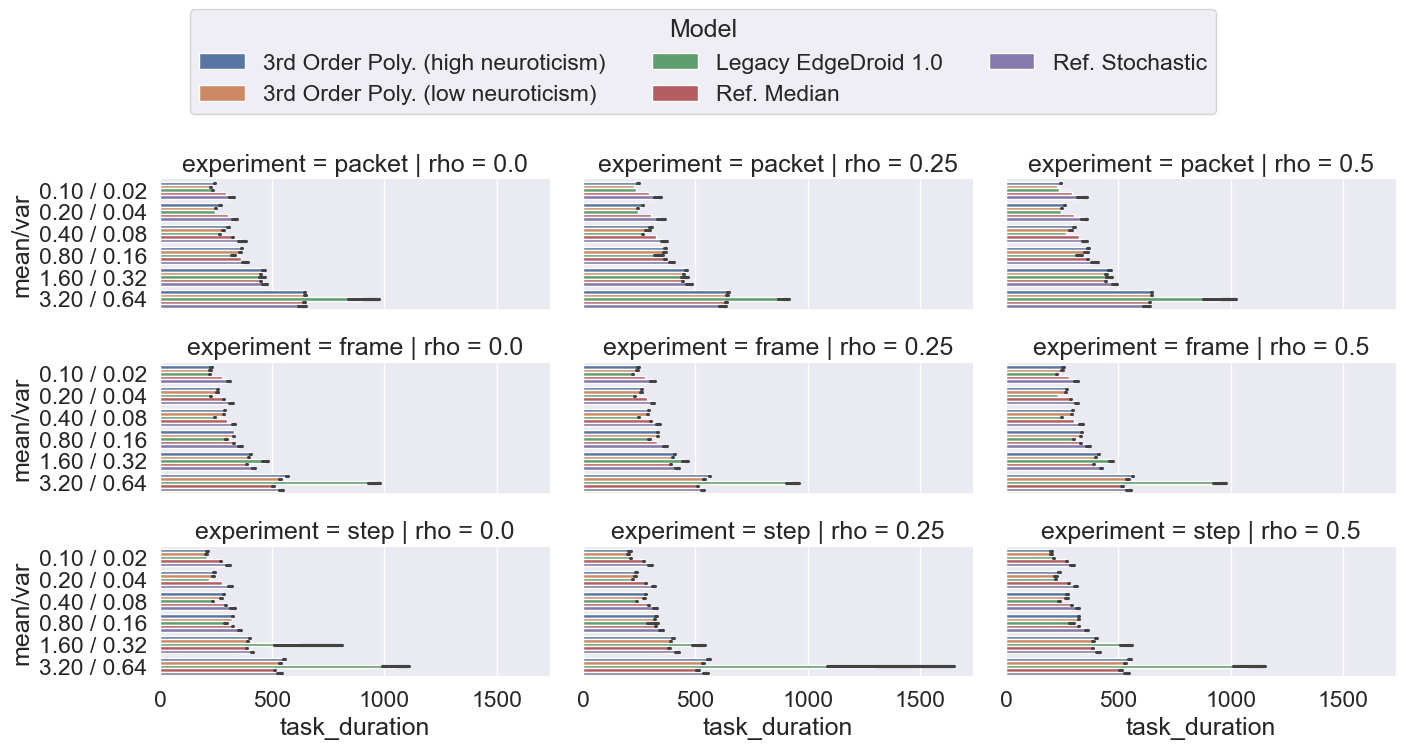

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

FULL_PAGE_WIDTH = 7.2

sns.set_context("paper")
sns.set(font_scale=1.5)

fg = sns.catplot(data=task_duration_data, kind="bar", x="task_duration", y="mean/var", hue="model", col="rho", row="experiment", legend_out=False)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
#     ax.yaxis.grid(True, which="minor")
#     ax.yaxis.grid(True, which="major")
#     ax.xaxis.grid(True)

sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.2), ncols=3)
fg.figure.set_size_inches((2*FULL_PAGE_WIDTH, 2*3.2))
fg.tight_layout()
plt.show()

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_59908/3478617607.py:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="mean/var", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


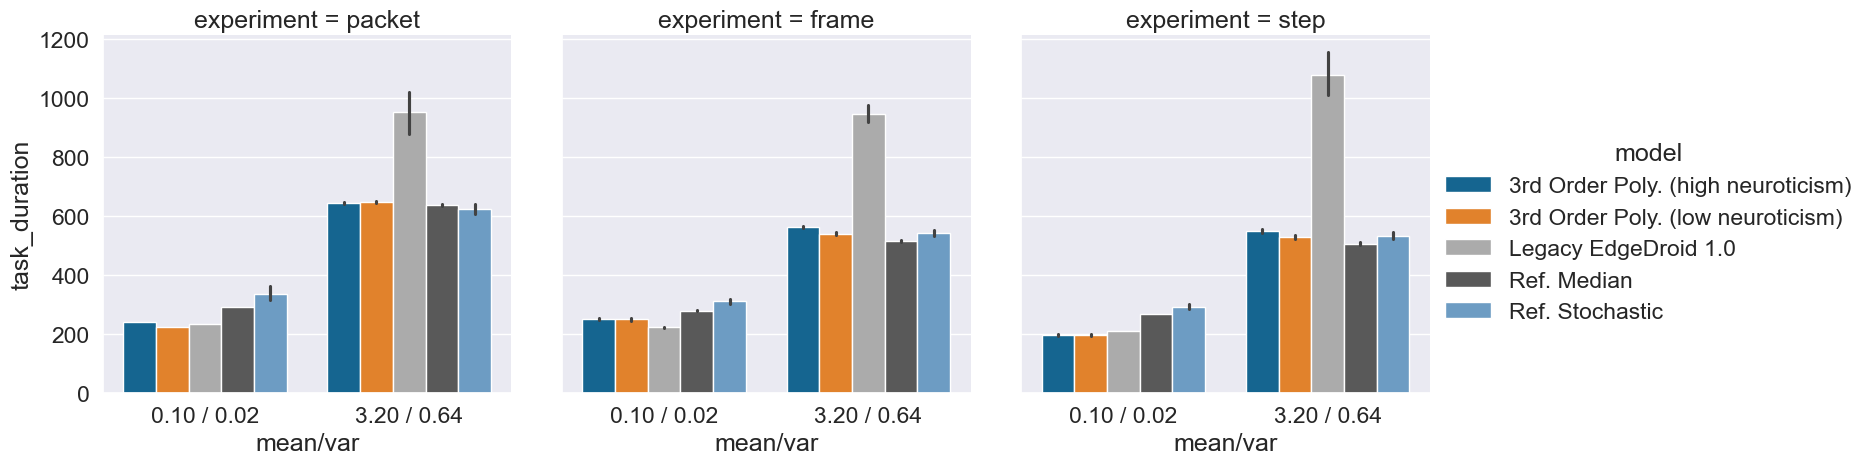

In [102]:
import numpy as np
from pypalettes import load_cmap

comp_data = task_duration_data[(task_duration_data.rho == 0.5) & np.isin(task_duration_data['mean/var'], ('0.10 / 0.02', '3.20 / 0.64'))].copy()
comp_data["mean/var"] = comp_data["mean/var"].cat.remove_unused_categories()

fg = sns.catplot(data=comp_data, kind="bar", x="mean/var", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()



/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_59908/444829788.py:4: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="rho", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


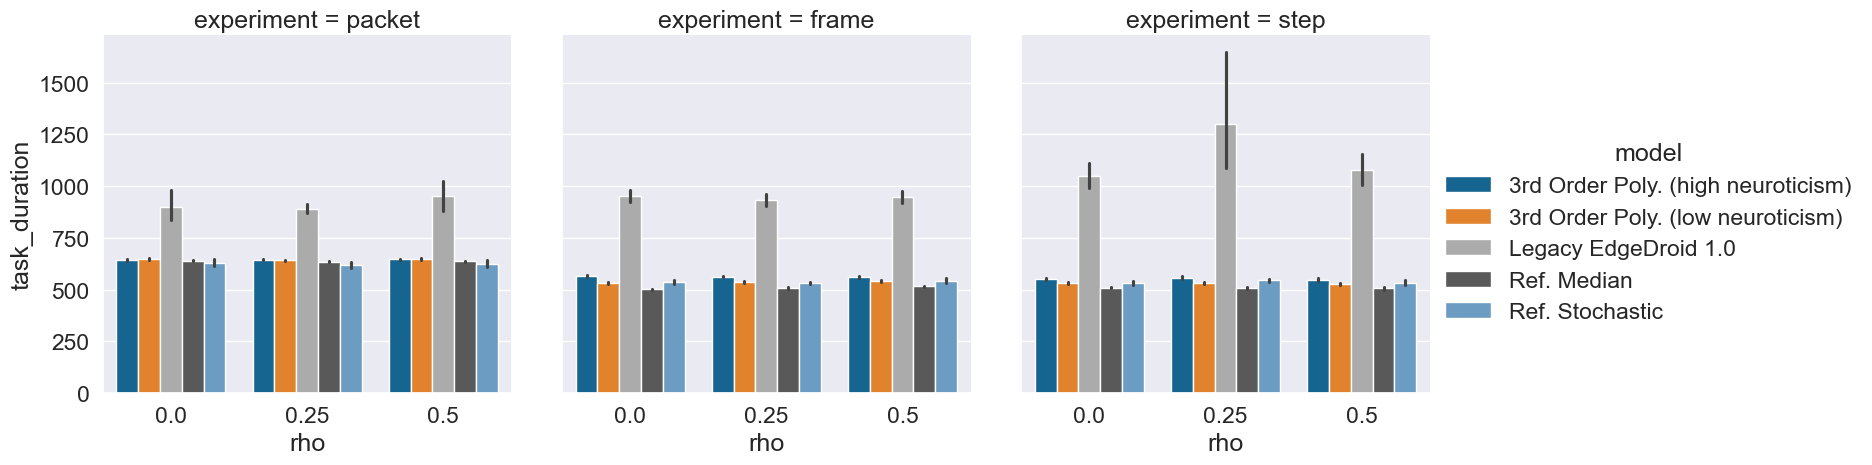

In [101]:
fg = sns.catplot(data=comp_data, kind="bar", x="rho", y="task_duration", hue="model", col="experiment", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_59908/1704616601.py:4: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  fg = sns.catplot(data=comp_data, kind="bar", x="rho", y="task_duration", hue="model", col="experiment", row="mean/var", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)


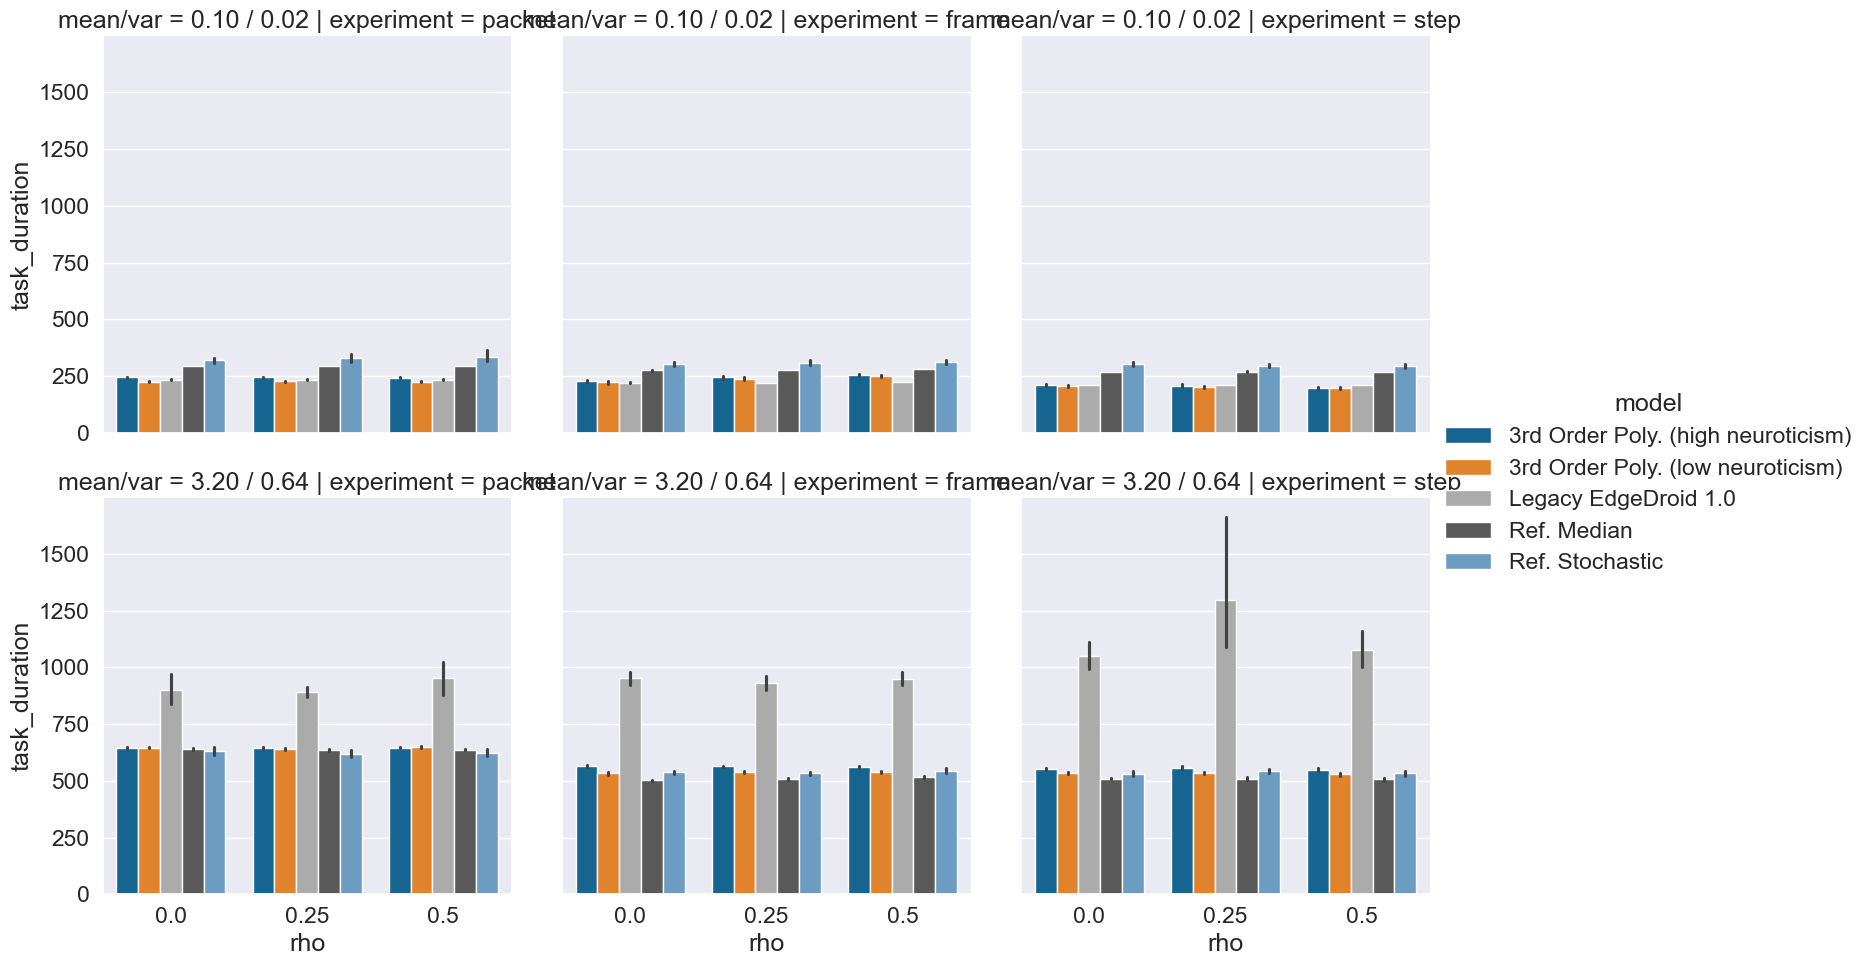

In [104]:
comp_data = task_duration_data[np.isin(task_duration_data['mean/var'], ('0.10 / 0.02', '3.20 / 0.64'))].copy()
comp_data["mean/var"] = comp_data["mean/var"].cat.remove_unused_categories()

fg = sns.catplot(data=comp_data, kind="bar", x="rho", y="task_duration", hue="model", col="experiment", row="mean/var", dodge=True, palette=load_cmap("Classic_Color_Blind").colors)
plt.show()

# Paper plots

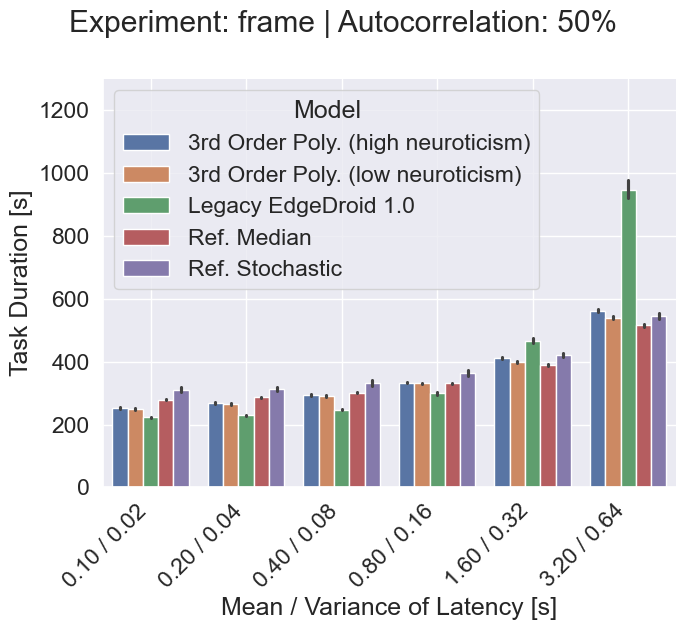

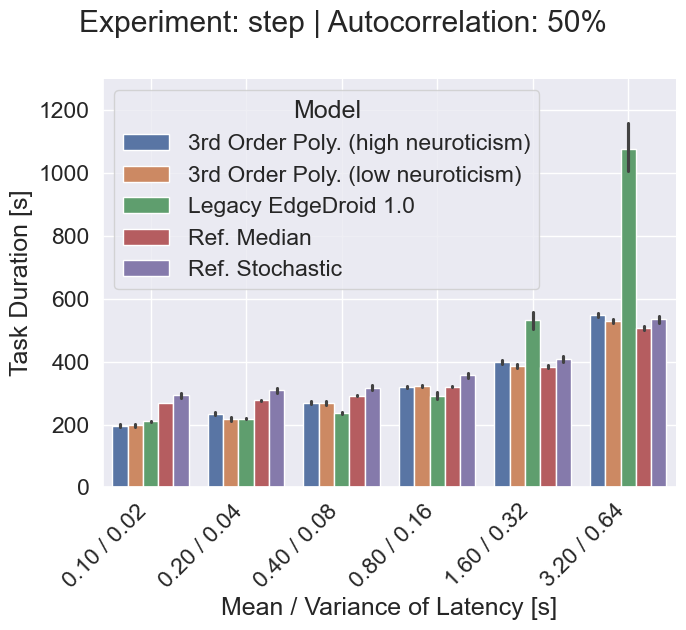

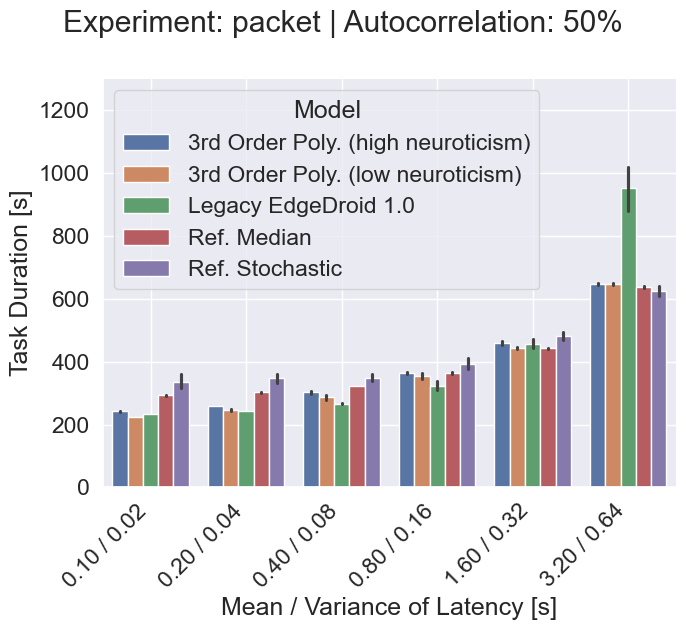

In [144]:
y_axis_max = 1300

for experiment in data.experiment.unique():
    fg = sns.catplot(
        data=task_duration_data[
            (task_duration_data["rho"] == 0.5) & (task_duration_data["experiment"] == experiment)
        ], 
        kind="bar", 
        x="mean/var", 
        y="task_duration", 
        hue="model",
        legend_out=False,
        dodge=True,
    )
    for ax in fg.axes.flat:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        ax.yaxis.grid(True, which="minor")
        ax.yaxis.grid(True, which="major")
        ax.xaxis.grid(True)
    
    fg.set(ylim=(None, y_axis_max))
    fg.set_axis_labels("Mean / Variance of Latency [s]", "Task Duration [s]")
    fg.legend.set_title("Model")
    fg.fig.set_size_inches(2*FULL_PAGE_WIDTH/2, 6.5)
    fg.fig.suptitle(f"Experiment: {experiment} | Autocorrelation: 50%")
    fg.fig.tight_layout()
    plt.show()

In [160]:
print(
    data
    .groupby(["gamma_mean", "gamma_var", "gamma_loc", "gamma_scale", "gamma_shape"], observed=True)
    .size()
    .reset_index()
    .drop(columns=[0])
    .to_latex(
        index=False,
        formatters={
            "gamma_mean": format_seconds,
            "gamma_var": format_seconds,
            "gamma_loc": lambda x: r"\SI{" f"{x:0.03f}" r"}{\second}",
            "gamma_scale": format_seconds, 
            "gamma_shape": lambda x: r"\num{" f"{x:0.03f}" r"}"
        }
    )
)

\begin{tabular}{lllll}
\toprule
gamma_mean & gamma_var & gamma_loc & gamma_scale & gamma_shape \\
\midrule
\SI{0.10}{\second} & \SI{0.02}{\second} & \SI{0.042}{\second} & \SI{0.34}{\second} & \num{0.168} \\
\SI{0.20}{\second} & \SI{0.04}{\second} & \SI{0.042}{\second} & \SI{0.25}{\second} & \num{0.624} \\
\SI{0.40}{\second} & \SI{0.08}{\second} & \SI{0.042}{\second} & \SI{0.22}{\second} & \num{1.602} \\
\SI{0.80}{\second} & \SI{0.16}{\second} & \SI{0.042}{\second} & \SI{0.21}{\second} & \num{3.591} \\
\SI{1.60}{\second} & \SI{0.32}{\second} & \SI{0.042}{\second} & \SI{0.21}{\second} & \num{7.586} \\
\SI{3.20}{\second} & \SI{0.64}{\second} & \SI{0.042}{\second} & \SI{0.20}{\second} & \num{15.583} \\
\bottomrule
\end{tabular}



In [171]:
def cross_difference_durations(df: pd.DataFrame) -> pd.DataFrame:
    realistic_df = df[np.isin(df["model"], ["3rd Order Poly. (low neuroticism)", "3rd Order Poly. (high neuroticism)"])].copy()
    reference_df = df[~np.isin(df["model"], ["3rd Order Poly. (low neuroticism)", "3rd Order Poly. (high neuroticism)"])].copy()
    
    cross_df = pd.merge(
        reference_df[["model", "task_duration"]],
        realistic_df[["model", "task_duration"]],
        suffixes=("_reference", "_realistic"),
        how="cross",
    )
    cross_df["task_duration_reldiff"] = (cross_df["task_duration_reference"] - cross_df["task_duration_realistic"]) / cross_df["task_duration_realistic"]
    return cross_df[["model_reference", "model_realistic", "task_duration_reldiff"]]
    
    
    
reldiff_data = task_duration_data.groupby(["experiment", "mean/var", "rho"], observed=True).apply(cross_difference_durations, include_groups=False).reset_index()
reldiff_data["label"] = reldiff_data[["model_reference", "model_realistic"]].apply(lambda row: f"{row.model_reference} diff. w.r.t. {'high' if 'high' in row.model_realistic else 'low'}", axis=1)
reldiff_data

,experiment,mean/var,rho,level_3,model_reference,model_realistic,task_duration_reldiff,label
0,packet,0.10 / 0.02,0.0,0,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.025626,Legacy EdgeDroid 1.0 diff. w.r.t. high
1,packet,0.10 / 0.02,0.0,1,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.019837,Legacy EdgeDroid 1.0 diff. w.r.t. high
2,packet,0.10 / 0.02,0.0,2,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.022249,Legacy EdgeDroid 1.0 diff. w.r.t. high
3,packet,0.10 / 0.02,0.0,3,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.025362,Legacy EdgeDroid 1.0 diff. w.r.t. high
4,packet,0.10 / 0.02,0.0,4,Legacy EdgeDroid 1.0,3rd Order Poly. (high neuroticism),-0.051303,Legacy EdgeDroid 1.0 diff. w.r.t. high
...,...,...,...,...,...,...,...,...
205195,step,3.20 / 0.64,0.5,5395,Ref. Stochastic,3rd Order Poly. (low neuroticism),0.011901,Ref. Stochastic diff. w.r.t. low
205196,step,3.20 / 0.64,0.5,5396,Ref. Stochastic,3rd Order Poly. (low neuroticism),0.025782,Ref. Stochastic diff. w.r.t. low
205197,step,3.20 / 0.64,0.5,5397,Ref. Stochastic,3rd Order Poly. (low neuroticism),-0.019769,Ref. Stochastic diff. w.r.t. low
205198,step,3.20 / 0.64,0.5,5398,Ref. Stochastic,3rd Order Poly. (low neuroticism),0.025742,Ref. Stochastic diff. w.r.t. low


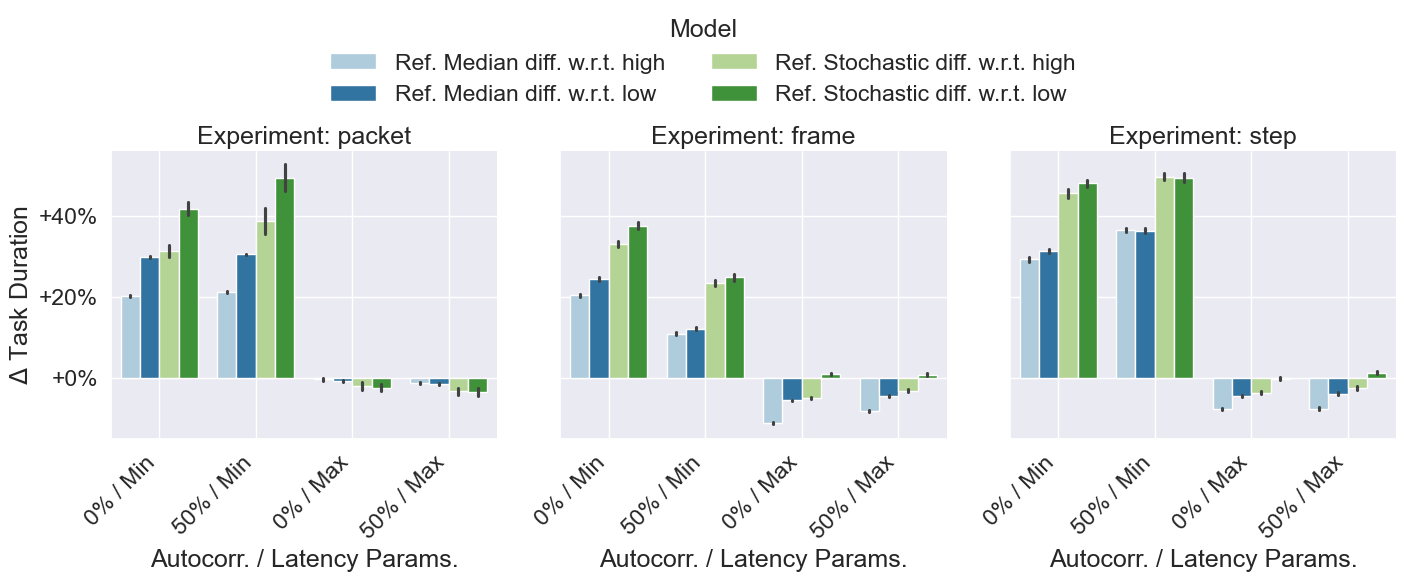

In [208]:
plot_data = reldiff_data[reldiff_data["model_reference"] != "Legacy EdgeDroid 1.0"].copy()
plot_data = plot_data[np.isin(plot_data["rho"], (0.0, 0.5)) & np.isin(plot_data["mean/var"], ("0.10 / 0.02", "3.20 / 0.64"))]
for col in ("mean/var", "model_reference", "rho"):
    plot_data[col] = plot_data[col].cat.remove_unused_categories()

plot_data["rho_pcnt"] = plot_data["rho"].apply(lambda r: f"{r:.0%}")
plot_data["latency_tag"] = plot_data["mean/var"].apply(lambda t: "Min" if "0.10" in t else "Max").astype(pd.CategoricalDtype(("Min", "Max"), ordered=True))
plot_data["rho_latency"] = plot_data[["rho_pcnt", "latency_tag"]].apply(lambda row: " / ".join([str(x) for x in row]), axis=1)

fg = sns.catplot(data=plot_data, kind="bar", hue="label", x="rho_latency", y="task_duration_reldiff", col="experiment", palette="Paired")
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)
    ax.yaxis.set_major_formatter("{x:+.0%}")

fg.set_axis_labels(r"Autocorr. / Latency Params.", r"$ \Delta $ Task Duration")
fg.set(ylim=(-0.15, None))
fg.set_titles(col_template="Experiment: {col_name}")
sns.move_legend(fg, "upper center", title="Model", bbox_to_anchor=(.5, 1.2), ncols=2)
fg.fig.set_size_inches(2*FULL_PAGE_WIDTH, 5)
fg.fig.tight_layout()

plt.show()